# 2. Cell Classifier
This note book is for classifying cells in the first BMC data set, annotated by Felicia.

In [1]:
import os
from pathlib import Path
import random
import numpy as np

from tqdm import tqdm
from PIL import Image, ImageDraw, ImageStat
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import json
import pandas as pd

import utils
import config
c = config.Config()

## Investigating data

In [21]:
from dataset import TNBC1
df = TNBC1().get_dataframe()
df['class'].value_counts()

tumor           658
immune cells    593
stroma          421
rbc              30
necrosis          6
Name: class, dtype: int64

In [22]:
# Dropping necrosis and rbc and stroma
df = df[df['class'] != 'rbc']
df = df[df['class'] != 'necrosis']
df = df[df['class'] != 'stroma']

In [23]:
def normalize_vertices(vertices):
    (x_min,y_min), (_, _) = utils.bounding_box(vertices)
    return [(x - x_min, y - y_min) for x, y in vertices]

def _bbox_to_slice(bbox):
    return (slice(int(bbox[0][1]), int(bbox[1][1]), None), 
            slice(int(bbox[0][0]), int(bbox[1][0]), None))

def generate_mask(vertices):
    img = Image.new("L", (3000, 3000), 0)
    ImageDraw.Draw(img).polygon(vertices, outline=1, fill=1)
    (left, upper), (right, lower) = utils.bounding_box(vertices)
    img = img.crop((left, upper, right+1, lower+1))
    return np.asarray(img)

df['vertices normalized'] = df['vertices'].apply(normalize_vertices)
df["obj"] = df["vertices"].apply(lambda x: _bbox_to_slice(utils.bounding_box(x)))
df['mask'] = df['vertices'].apply(generate_mask)
df['size'] = df['mask'].apply(np.sum)
df = df[df['size'] != 0]

Text(0.5, 1.0, 'Major and minor axis ratio')

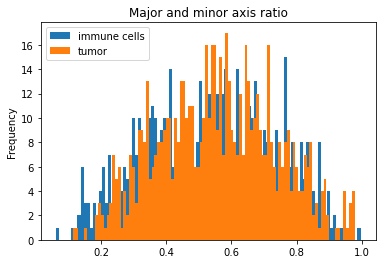

In [5]:
# Exploring major and minor axis
# https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/

def major_minor_axis(mask):
    if np.sum(mask) < 2:
        return 0, 0
    y, x = np.nonzero(mask)
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    
    v2, v1 = np.sort(evals)
    return v1, v2

df['major axis'] = df['mask'].apply(lambda x: major_minor_axis(x)[0])
df['minor axis'] = df['mask'].apply(lambda x: major_minor_axis(x)[1])
df['axis ratio'] = df['minor axis'] / df['major axis']
df.groupby('class')['axis ratio'].plot.hist(bins = 100)
plt.legend()
plt.title('Major and minor axis ratio')

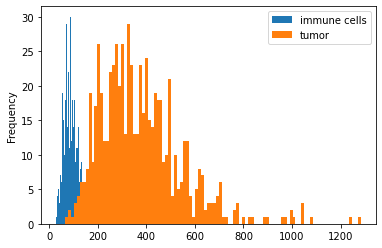

In [6]:
# Size Size varies between classes
plt.figure()
df.groupby('class')['size'].plot.hist(bins = 100)
plt.legend()

In [7]:
def brightness_mean(im):
    return np.nanmean(np.ravel(np.where(im!=0,im,np.nan)))
        
def brightness_var(im):
    return np.var(np.ravel(im))
    
    
def avg_brightness(ids, masks, obj, image_dict):
    avg = []
    var = []
    
    for imid, mask, obj in zip(ids, masks, obj):
        img = image_dict[imid][obj]
        mask = mask[:img.shape[0], :img.shape[1]]
        img = img[:mask.shape[0], :mask.shape[1], :]
        img = img * np.dstack((mask, mask, mask))
        m = brightness_mean(img)
        v = brightness_var(img)
        
        if m is None or v is None:
            avg.append(0)
            var.append(0)
        else:
            avg.append(m)
            var.append(v)
    return avg, var

Text(0.5, 1.0, 'Brightness variance')

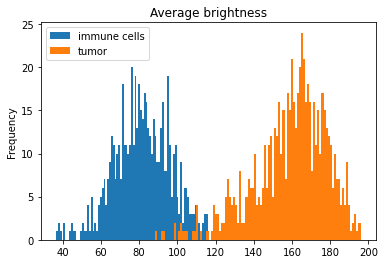

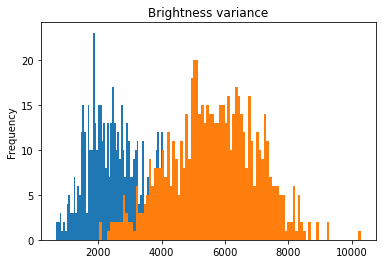

In [8]:
tnbc = TNBC1()
image_dict = dict([(imid, tnbc.load_image(imid)) for imid in tnbc.ids])
df["avg_brightness"], df["var_brightness"] = avg_brightness(df["image_id"], df["mask"], df["obj"], image_dict)
df.groupby('class')["avg_brightness"].plot.hist(bins=100)
plt.legend()
plt.title("Average brightness")
plt.figure()
df.groupby('class')["var_brightness"].plot.hist(bins=100)
plt.title("Brightness variance")

## Training basic model
We've found that the size, and brightness differ between classes. We will use these as features.


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import pickle
import time

features = ['avg_brightness', 'var_brightness', 'size']
classes = ['tumor', 'immune cells']
df_class = pd.get_dummies(df['class'])
df_features = pd.concat([df_class, df[features]], axis=1)

np.random.seed(0) # Set random seed for test/train-split
msk = np.random.rand(len(df_features)) < 0.8
df_test = df_features[~msk]
df_train = df_features[msk]

X = df_train[features]
y = df_train[classes]

kf = KFold(n_splits=5,shuffle=True)
kf.split(X)

t = 1000 * time.time() # current time in milliseconds
np.random.seed(int(t) % 2**32)
cm_list = []
for train_index, val_index in kf.split(X):
    x_train, x_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = LogisticRegression(random_state=0)
    model.fit(x_train, y_train.values[:,1])
    y_pred = model.predict(x_val)
    y_val = y_val.values.argmax(axis=1)
    cm_list.append(confusion_matrix(y_val, y_pred, normalize='true'))
    
    
with open(c.MODEL_DIR / 'cell_classifier.pickle', 'wb') as f:
    pickle.dump((features, model), f)


### Evaluation
The validation scores seem pretty promesing.

<AxesSubplot:>

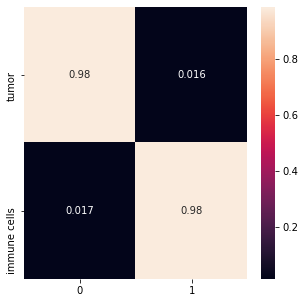

In [10]:
import seaborn as sn
df_cm = pd.DataFrame(np.mean(cm_list, axis=0), index = classes)
plt.figure(figsize=(5,5))
sn.heatmap(df_cm, annot=True)

## Classifying masks predicted by U-Net

In [28]:
import predict
import importlib
importlib.reload(predict)
from predict import make_pred, post_processing, make_pred_dataframe

masks = {}
tnbc = TNBC1()
for im_id in tqdm(df["image_id"].unique(), desc="Making masks"):
    path = tnbc.file_name(im_id)
    masks[im_id] = post_processing(make_pred(path, 'unet_quip_ds_aug', int(c.WIDTH*3/2)), 0.03)

Making masks: 100%|██████████| 80/80 [00:37<00:00,  2.14it/s]


In [29]:
df = df[df["image_id"].isin(masks.keys())]
df["unet_mask"] = df.apply(lambda x: masks[x.image_id][x.obj], axis=1)
df["unet_avg_brightness"], df["unet_var_brightness"] = avg_brightness(df["image_id"], df["unet_mask"], df["obj"], image_dict)
df["unet_size"] = df["unet_mask"].apply(np.sum)

<ipython-input-7-721f1a0bf6dd>:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.ravel(np.where(im!=0,im,np.nan)))


KeyError: 'Column not found: avg_brightness'

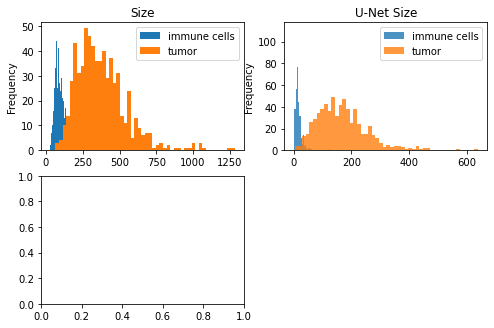

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(321)
df.groupby("class")["size"].plot.hist(bins=50)
plt.title("Size")
plt.legend()
plt.subplot(322)
df.groupby("class")["unet_size"].plot.hist(bins=50, alpha=0.8)
plt.title("U-Net Size")
plt.legend()
plt.subplot(323)
df.groupby("class")["avg_brightness"].plot.hist(bins=50)
plt.title("Brightness")
plt.legend()
plt.subplot(324)
df.groupby("class")["unet_avg_brightness"].plot.hist(bins=50, alpha=0.8)
plt.title("U-Net brightness")
plt.legend()
plt.subplot(325)
df.groupby("class")["var_brightness"].plot.hist(bins=50, alpha=0.8)
plt.title("Brightness variance")
plt.legend()
plt.subplot(326)
df.groupby("class")["unet_var_brightness"].plot.hist(bins=50, alpha=0.8)
plt.title("U-Net brightness variance")
plt.legend()

<Figure size 432x288 with 0 Axes>

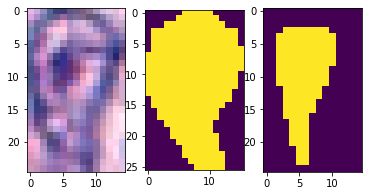

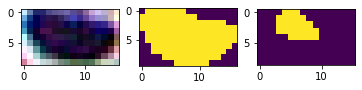

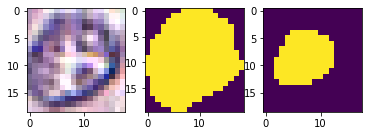

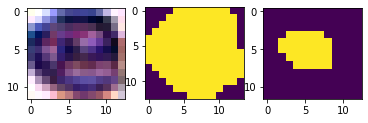

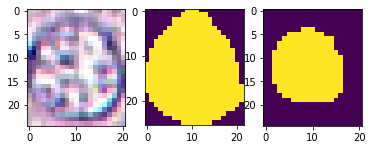

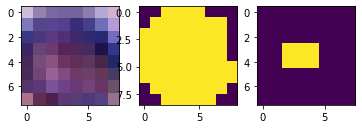

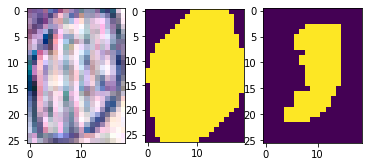

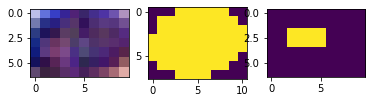

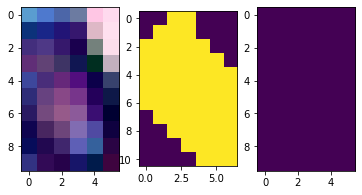

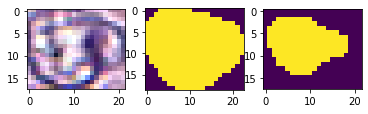

In [30]:
plt.figure()
tnbc = TNBC1()
for idx, row in df.sample(10, axis=0).iterrows():
    plt.figure()
    plt.subplot(131)
    plt.imshow(tnbc.load_image(row["image_id"])[row["obj"]])
    plt.subplot(132)
    plt.imshow(row["mask"])
    plt.subplot(133)
    plt.imshow(row["unet_mask"])

In [31]:
# Most missing cells are immune cells
print((df[df["unet_size"] == 0]["class"].value_counts()))

immune cells    103
Name: class, dtype: int64


<AxesSubplot:>

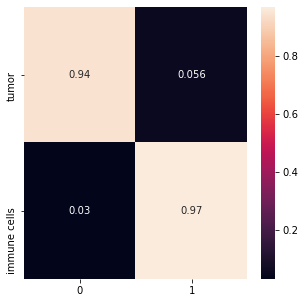

In [16]:
# Droping missing cells
df = df[df["unet_size"] > 0] 
df["pred_class"] = model.predict(df[[f"unet_{f}" for f in features]].iloc[:])
df["pred_class"] = df["pred_class"].apply(lambda x: classes[x])

cm = confusion_matrix(df["class"], df["pred_class"], normalize='true')
df_cm_unet = pd.DataFrame(cm, index = classes)
plt.figure(figsize=(5,5))

# Of none-missing cells most are correclty classified
sn.heatmap(df_cm_unet, annot=True)

In [17]:
df_pred = pd.concat([make_pred_dataframe(imid, mask, tnbc.load_image(imid))
                        for imid, mask in tqdm(masks.items())])

100%|██████████| 80/80 [01:13<00:00,  1.09it/s]


In [18]:
df_pred["class_name"].value_counts()

tumor            393215
immunes cells     91765
Name: class_name, dtype: int64

  0%|          | 0/9 [00:00<?, ?it/s]<ipython-input-19-8b4f30483f58>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(221)
100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


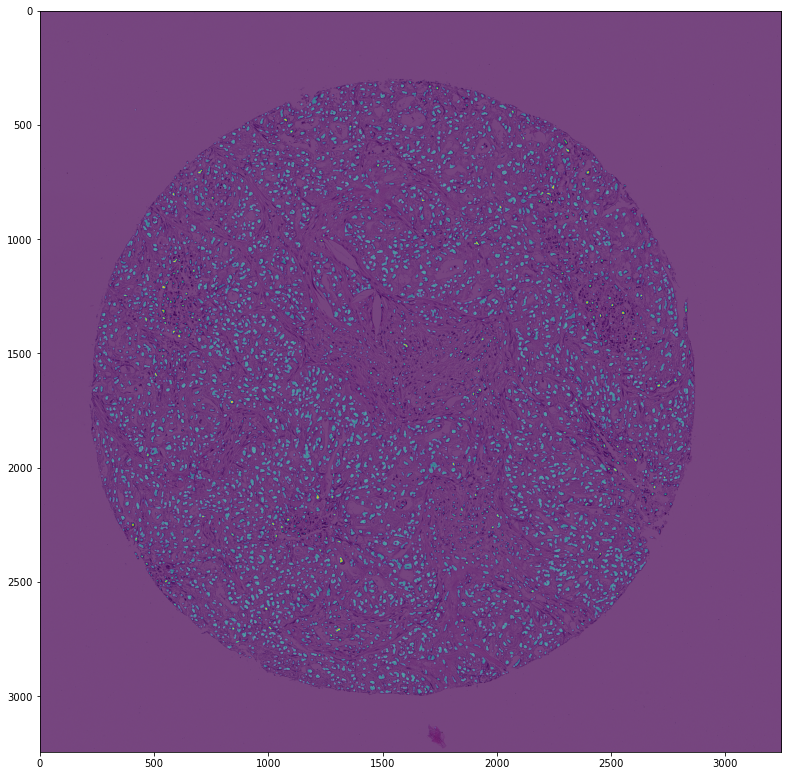

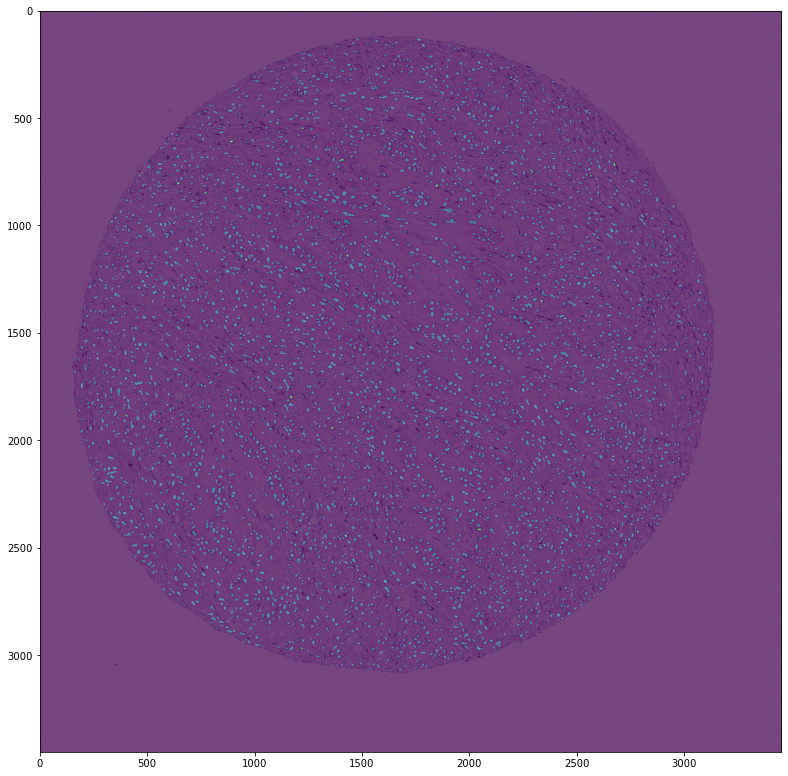

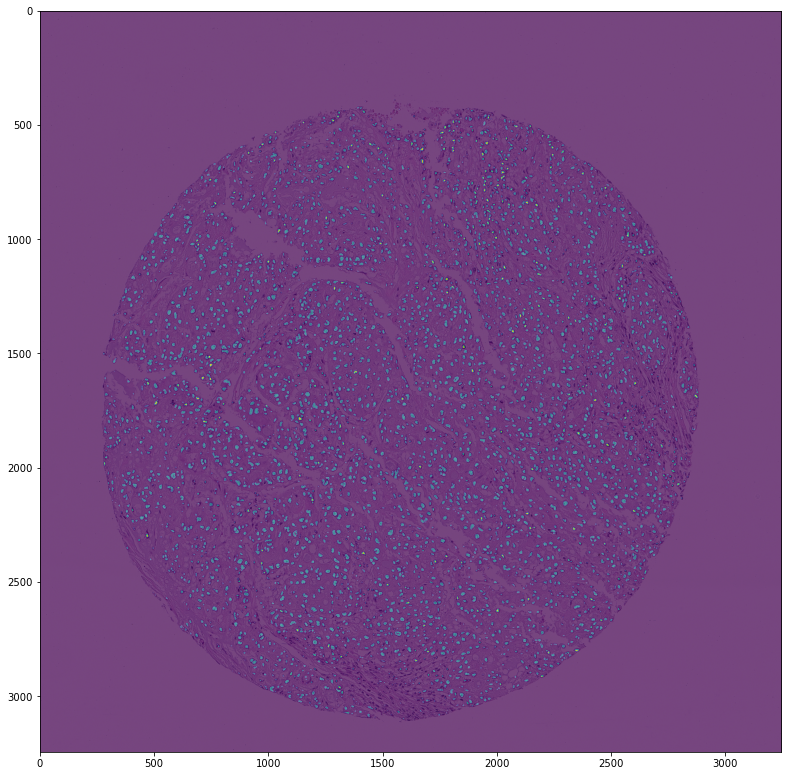

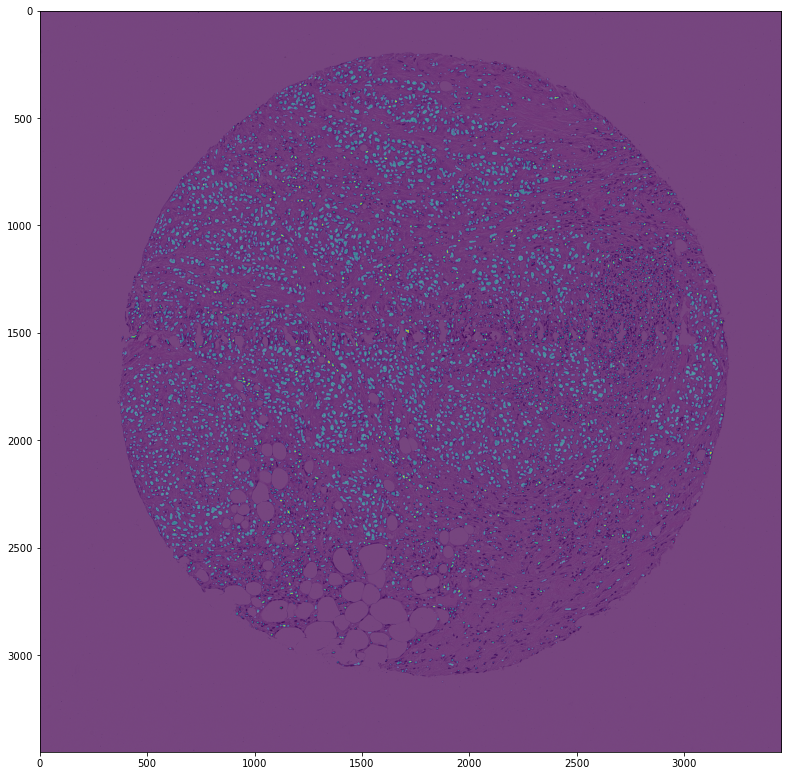

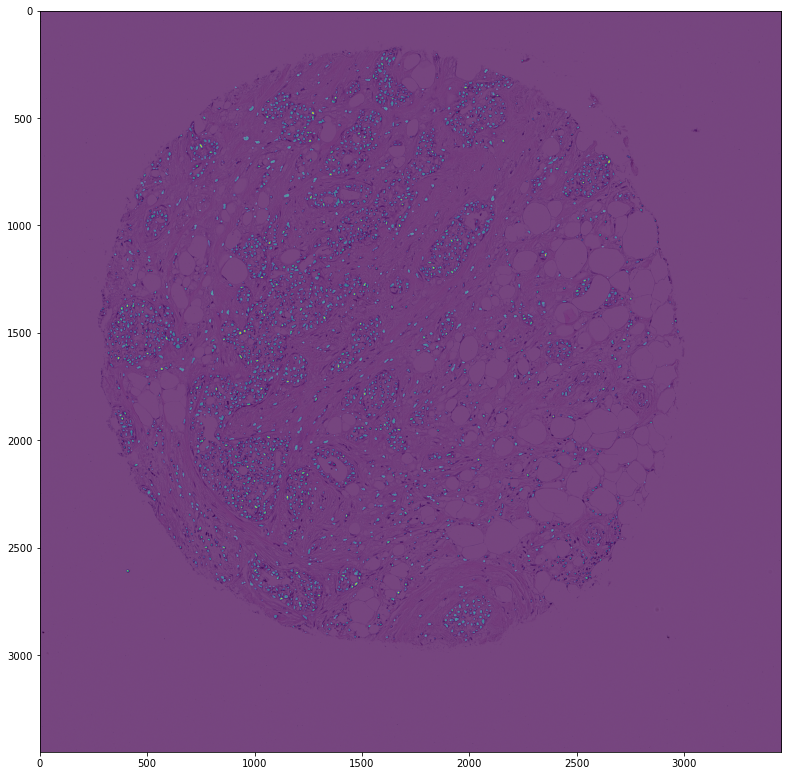

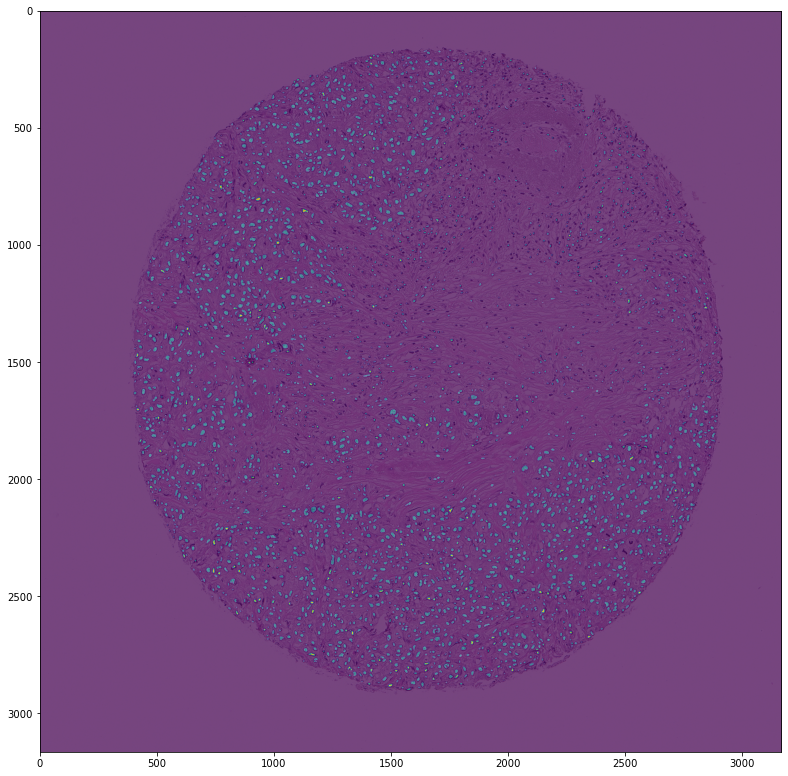

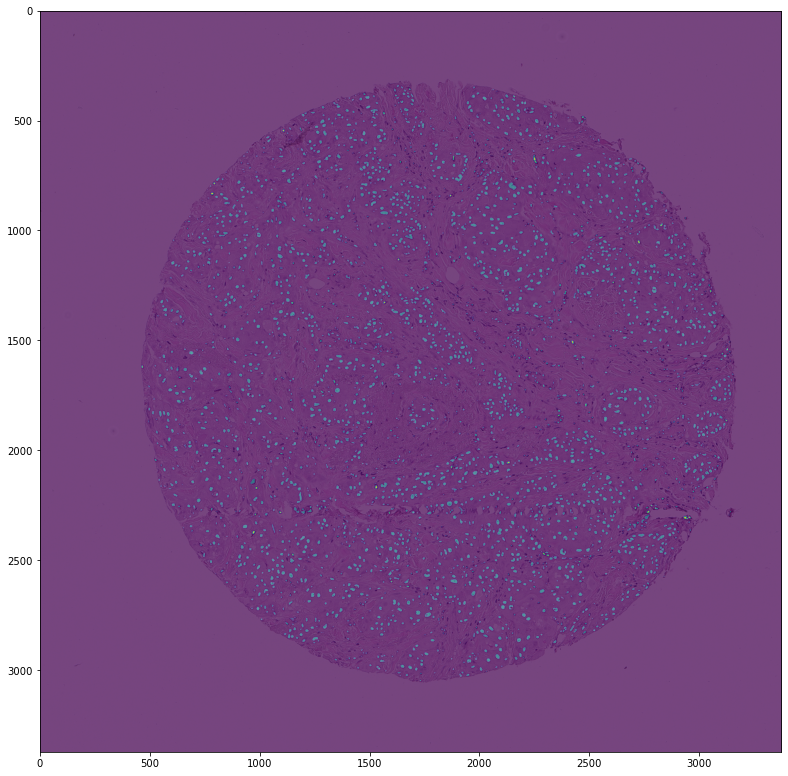

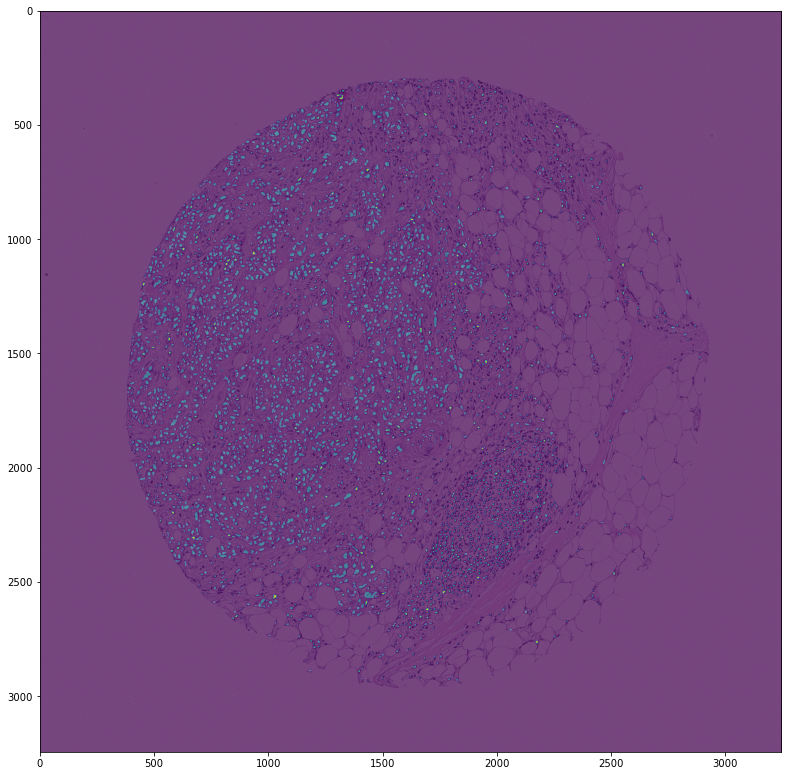

Error in callback <function flush_figures at 0x7fca3404c940> (for post_execute):


KeyboardInterrupt: 

In [19]:
# Displaying results
import random
cells = {}
for imid in tqdm(random.choices(df["image_id"].unique(), k=9)):
    img = TNBC1().load_image(imid)
    pred = np.zeros((img.shape[0], img.shape[1]))
    for _, row in df_pred[df_pred["image_id"] == imid].iterrows():
        pred[row["obj"]] = (1 + row["class"]) * row["mask"]

    cells[imid] = pred
    plt.figure(figsize=(30,30))
    plt.subplot(221)
    plt.imshow(pred)
    plt.subplot(221)
    plt.imshow(img, alpha=0.3)